In [34]:
def extract_game_end(message, player):
    # Is decisive?
    if "won" in message:
        # Check if player won:
        if player in message:
            win = 1
        else:
            win = 0
        # Which Ending?
        if "resignation" in message:
            termination = "resignation"
        elif "checkmate" in message:
            termination = "checkmate"
        elif "time" in message:
            termination = "time"
        else:
            assert ValueError, f"Secret Third Thing in {message}"

    else:
        win = 0.5
        # Which Ending:
        if "repetition" in message:
            termination = "repetition"
        elif "insufficient" in message:
            termination = "insufficient material"
        elif "agreement" in message:
            termination = "agreement"
        elif "50-move rule" in message:
            termination = "50-move rule"
        elif "stalemate" in message:
            termination = "stalemate"
        else:
            assert ValueError, f"Secret Sixth Thing in {message}"
    
    return win, termination

  1%|          | 275/54073 [00:00<01:18, 685.85it/s]/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 54073/54073 [01:26<00:00, 624.77it/s]


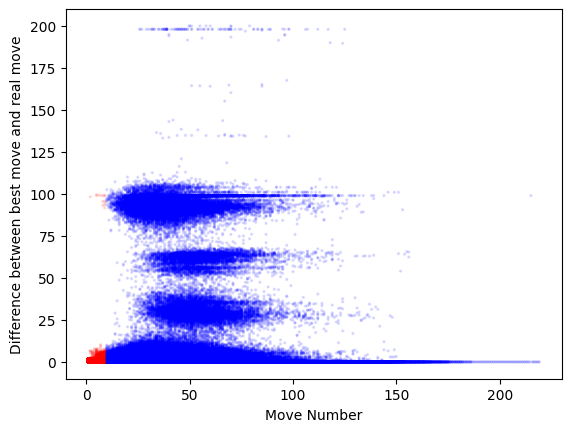

In [35]:
import json 
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

files = os.listdir('../Data/Analysed')

datas = []
players = {}
all_obs = [] 
games = []
# playername, rating, difference, time 
for file in tqdm(files):
    with open('../Data/Analysed/' + file) as f:
        data = json.load(f)
    
    white_moves_time, black_moves_time = data["game"]["moveTimestamps"].split(",")[:-1][::2], data["game"]["moveTimestamps"].split(",")[:-1][1::2]
    white_moves_time, black_moves_time = [int(x)/10 for x in white_moves_time], [int(x)/10 for x in black_moves_time]
    time_diffs_white, time_diffs_black = [0] + list(np.diff(white_moves_time)), [0] + list(np.diff(black_moves_time))
    
    user_black = data["players"]["top"]["username"]
    user_white = data["players"]["bottom"]["username"]
    rating_black = data["players"]["top"]["rating"]
    rating_white = data["players"]["bottom"]["rating"]

    white_loss = [x["difference"] for x in data["evaluations"] if x["player"] == "white"]
    black_loss = [x["difference"] for x in data["evaluations"] if x["player"] == "black"]
    white_loss_after_10 = np.median(white_loss[10:])
    black_loss_after_10 = np.median(black_loss[10:])
    white_loss = np.median(white_loss)
    black_loss = np.median(black_loss)
    white_perc_best_move = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"] if x["player"] == "white"])
    black_perc_best_move = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"] if x["player"] == "black"])
    white_perc_very_good_move = np.mean([x["Ranking Real Move"] <= 3 for x in data["evaluations"] if x["player"] == "white"])
    black_perc_very_good_move = np.mean([x["Ranking Real Move"] <= 3 for x in data["evaluations"] if x["player"] == "black"])

    white_perc_best_move_after_10 = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"][10:] if x["player"] == "white"])
    black_perc_best_move_after_10 = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"][10:] if x["player"] == "black"])
    # Ranking Real Move (if -1 => 10)
    avg_rank_white = np.mean([x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "white"])
    avg_rank_black = np.mean([x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "black"])
    ranks_white = [x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "white"]
    ranks_black = [x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "black"]

    if user_black not in players:
        players[user_black] = {"games": 0, "loss": [], "loss_after_10": [], "perc_best_move": [], "perc_best_move_after_10": [], "rating": [], "avg_rank": [], "ranks": [], "very_good_move": []}
    if user_white not in players:
        players[user_white] = {"games": 0, "loss": [], "loss_after_10": [], "perc_best_move": [], "perc_best_move_after_10": [], "rating": [], "avg_rank": [], "ranks": [], "very_good_move": []}
    
    players[user_black]["games"] += 1
    players[user_white]["games"] += 1
    players[user_black]["loss"].append(black_loss)
    players[user_white]["loss"].append(white_loss)
    players[user_black]["loss_after_10"].append(black_loss_after_10)
    players[user_white]["loss_after_10"].append(white_loss_after_10)
    players[user_black]["perc_best_move"].append(black_perc_best_move)
    players[user_white]["perc_best_move"].append(white_perc_best_move)
    players[user_black]["perc_best_move_after_10"].append(black_perc_best_move_after_10)
    players[user_white]["perc_best_move_after_10"].append(white_perc_best_move_after_10)
    players[user_black]["rating"].append(rating_black)
    players[user_white]["rating"].append(rating_white)
    players[user_black]["avg_rank"].append(avg_rank_black)
    players[user_white]["avg_rank"].append(avg_rank_white)
    players[user_black]["ranks"].append(ranks_black)
    players[user_white]["ranks"].append(ranks_white)
    players[user_black]["very_good_move"].append(black_perc_very_good_move)
    players[user_white]["very_good_move"].append(white_perc_very_good_move)

    white_moves, black_moves = 0, 0
    for i in range(len(data["evaluations"])):
        white_moves += 1 if data["evaluations"][i]["player"] == "white" else 0
        black_moves += 1 if data["evaluations"][i]["player"] == "black" else 0
        player = user_black if i % 2 == 0 else user_white
        win, termination = extract_game_end(data["game"]["resultMessage"],player)
        all_obs.append({"player": player, 
                        "colour": 0 if i % 2 == 0 else 1,
                        "rating":  np.mean(players[user_black]["rating"]) if i % 2 == 0 else np.mean(players[user_white]["rating"]),
                        "difference": -np.abs(data["evaluations"][i]["Best Move Eval"] - data["evaluations"][i]["Real Move Eval"]),
                        "time": time_diffs_white[white_moves-1] if data["evaluations"][i]["player"] == "white" else time_diffs_black[black_moves-1],
                        "remaining_time": white_moves_time[white_moves-1] if data["evaluations"][i]["player"] == "white" else black_moves_time[black_moves-1],
                        "Ranking Real Move": data["evaluations"][i]["Ranking Real Move"],
                        "Move_Num" : white_moves if data["evaluations"][i]["player"] == "white" else black_moves,
                        "opponent": user_white if i % 2 == 0 else user_black,
                        "game_id": data["game"]["id"],
                        "oppenent_rating": np.mean(players[user_white]["rating"]) if i % 2 == 0 else np.mean(players[user_black]["rating"]),
                        "real_eval": data["evaluations"][i]["Real Move Eval"],
                        "best_eval": data["evaluations"][i]["Best Move Eval"],
                        "result": win,
                        "termination": termination})
        
all_obs = [x for x in all_obs if not any((isinstance(value, float) and np.isnan(value)) or value is None for value in x.values())]
all_obs_df = pd.DataFrame(all_obs)
all_obs_df["difference"] = all_obs_df["difference"] * -1
all_obs_df["blunder"] = all_obs_df["difference"] > 2
all_obs_df["blunder"] = all_obs_df["difference"] > 1
blunds = all_obs_df.groupby("player").agg({"blunder": "mean", "rating": "first", "difference": "size"}).reset_index()
blunds.columns = ["player", "blunder", "rating", "games"]
plt.scatter(all_obs_df["Move_Num"], all_obs_df["difference"], c=all_obs_df["Move_Num"] < 10, cmap="bwr", alpha=0.1, s = 2)
plt.xlabel("Move Number")
plt.ylabel("Difference between best move and real move")
df = pd.DataFrame(players).T

In [36]:
all_obs_df['best_move'] = all_obs_df['Ranking Real Move'] == 1
all_obs_df['blunder_rank'] = all_obs_df['Ranking Real Move'] == -1
all_obs_df['blunder'] = np.abs(all_obs_df['difference']) > 2

In [37]:
# Extract max and min rating for each player
min_max = all_obs_df.groupby("player").agg({"rating": ["min", "max"]}).reset_index()

In [38]:
all_games = all_obs_df.groupby(['player', 'game_id']).agg({'rating': 'first',
                                                'oppenent_rating': 'first',
                                                'best_move': 'mean',
                                                'blunder_rank': 'mean',
                                                'blunder': 'mean',
                                                'difference':"mean"}).reset_index()

Text(0.5, 1.0, 'Blunder Rate Heatmap')

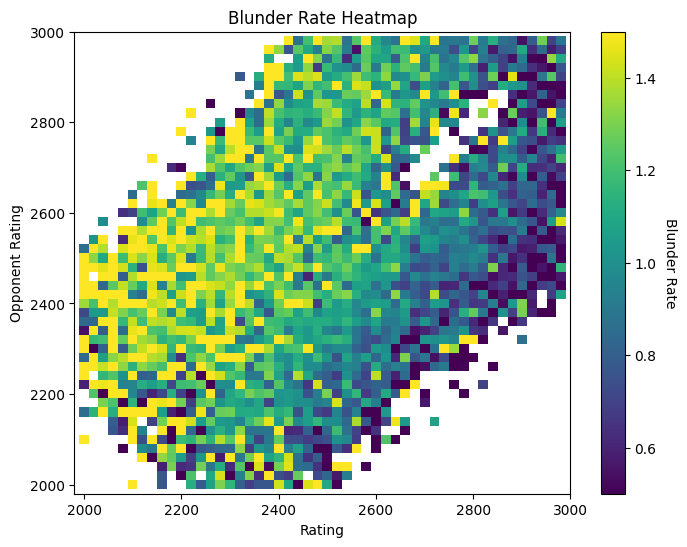

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already created all_obs_df DataFrame and it contains columns 'rating' and 'oppenent_rating'

# Create bins of ratings
# Determine the range and bins based on 'rating' column
all_games = all_games[(all_games.rating > 2000) & (all_games.rating < 3000) & (all_games.oppenent_rating > 2000) & (all_games.oppenent_rating < 3000)]
min_rating = all_games['rating'].min()
max_rating = all_games['rating'].max()
bins = np.linspace(min_rating, max_rating, 51)  # 100 bins

# Use the same bins for both 'rating' and 'opponent_rating'
all_games['rating_bin'] = pd.cut(all_games['rating'], bins=bins, labels=False, include_lowest=True)
all_games['opponent_rating_bin'] = pd.cut(all_games['oppenent_rating'], bins=bins, labels=False, include_lowest=True)


# Remove all groups of size < 100
big_groups = all_games.groupby(['rating_bin', 'opponent_rating_bin']).filter(lambda x: len(x) >= 5)

# Filter out all observations not in big groups
all_games = all_games[all_games.index.isin(big_groups.index)]

# Group by the binned ratings and calculate median difference
grouped = all_games.groupby(['rating_bin', 'opponent_rating_bin'])['difference'].apply(np.nanmean).reset_index()


# Create pivot table for the heatmap
heatmap_data = grouped.pivot(index='rating_bin', columns='opponent_rating_bin', values='difference')

# For better visualization, we'll take a logarithm of the absolute difference values
heatmap_data_log = np.log(np.abs(heatmap_data) + 1e-3)

# Creating tick positions and labels for the x and y axes
rating_bins = np.linspace(all_games['rating'].min(), all_games['rating'].max(), 51)
opponent_rating_bins = np.linspace(all_games['oppenent_rating'].min(), all_games['oppenent_rating'].max(), 51)



plt.figure(figsize=(8, 6))
# Heatmap with reversed colormap
plt.imshow(heatmap_data, cmap='viridis', origin='lower', aspect='auto', vmin=0.5, vmax=1.5)
# set ticks
tick_locs = np.linspace(0, 50, 6)  # 6 tick locations
tick_labels = np.round(rating_bins[::10]).astype(int)  # 6 labels

# Set the x and y ticks using these
plt.xticks(tick_locs, tick_labels)
plt.yticks(tick_locs, tick_labels) 
# Colorbar cap at 0 - 0.05
cbar = plt.colorbar()
cbar.set_label('Blunder Rate', rotation=270, labelpad=15)

bin_index_2000 = np.digitize(2000, rating_bins) - 1
bin_index_3000 = np.digitize(3000, rating_bins) - 1

plt.xlim(bin_index_2000, bin_index_3000)
plt.ylim(bin_index_2000, bin_index_3000)
plt.xlabel('Rating')
plt.ylabel('Opponent Rating')
plt.title('Blunder Rate Heatmap')


In [25]:
one_obs_per_player = all_obs_df.groupby(["game_id"]).first()
big_players = one_obs_per_player.groupby("player").size()[one_obs_per_player.groupby("player").size() > 50].index
one_obs_per_player[one_obs_per_player.player.isin(big_players)].groupby("player").result.mean().sort_values(ascending = False).head(20)

player
MagnusCarlsen           0.798780
OparinGrigoriy          0.798246
LyonBeast               0.783019
Firouzja2003            0.766667
FabianoCaruana          0.756098
Hikaru                  0.753289
Polish_fighter3000      0.745455
Duhless                 0.742647
nihalsarin              0.739362
Njal28                  0.733333
BogdanDeac              0.727679
FairChess_on_YouTube    0.721622
rasmussvane             0.719828
Bigfish1995             0.715278
dropstoneDP             0.711538
Oleksandr_Bortnyk       0.709559
crescentmoon2411        0.701923
Jospem                  0.695266
DanielNaroditsky        0.692982
baki83                  0.690476
Name: result, dtype: float64

In [26]:
all_obs_df['draw'] = all_obs_df['result'] == 0.5
one_obs_per_player = all_obs_df.groupby(["game_id"]).first()
big_players = one_obs_per_player.groupby("player").size()[one_obs_per_player.groupby("player").size() > 50].index
one_obs_per_player[one_obs_per_player.player.isin(big_players)].groupby("player").draw.mean().sort_values(ascending = False).head(20)

player
guillembaches           0.338462
Schattman               0.297619
Coachpoker              0.275362
AlexanderL              0.258065
DanielNaroditsky        0.245614
Goryachkina             0.245283
stollenmonster          0.230769
GeorgiosSouleidis       0.222222
sergiochess83           0.219780
dropstoneDP             0.217949
LyonBeast               0.207547
Msb2                    0.204082
TigrVShlyape            0.202797
FairChess_on_YouTube    0.200000
The_Machine04           0.196078
GMWSO                   0.196078
RobertoJBM              0.191781
jefferyx                0.188235
Cambek64                0.184211
Firouzja2003            0.183333
Name: draw, dtype: float64

In [27]:
def get_longest_1_count(l):        
    if len(l) < 11:
        return 0
    longest = 0
    current = 0
    for i in l[10:]:
        if i == 1:
            current += 1
        else:
            if current > longest:
                longest = current
            current = 0
    return longest

def get_longest_list_of_lists(x):
    if isinstance(x[0], list):
        return [get_longest_1_count(l) for l in x]
    else:
        return [get_longest_1_count(x)]
        

df["longest_first"] = df.ranks.apply(get_longest_list_of_lists)
# All columns except for "games" - are lists
# calculate the mean of each list
for col in df.columns:
    if col != "games" and col != "ranks":
        # Ignore NAs in the mean calculation
        df[col] = df[col].apply(lambda x: np.nanmean(x))

/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/2883018305.py:28: RuntimeWarning: Mean of empty slice
  df[col] = df[col].apply(lambda x: np.nanmean(x))


In [28]:
#plt.scatter(df.loc[df["games"] > min_games, "rating"], df.loc[df["games"] > min_games,"loss"], s= [10 * x for x in df.loc[df["games"] > min_games,"games"].to_list()])
import statsmodels.api as sm
min_games = 10
X = df.loc[df["games"] > min_games, "rating"]
y = df.loc[df["games"] > min_games,"loss"]
X = X[~y.isna()]
y = y[~y.isna()]
X = sm.add_constant(X)
OLS = sm.OLS(y, X).fit()

/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/2017431347.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df["games"] > min_games,"rating"][i] > 3200:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/2017431347.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df["games"] > min_games,"loss"][i] > 0.25:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/2017431347.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

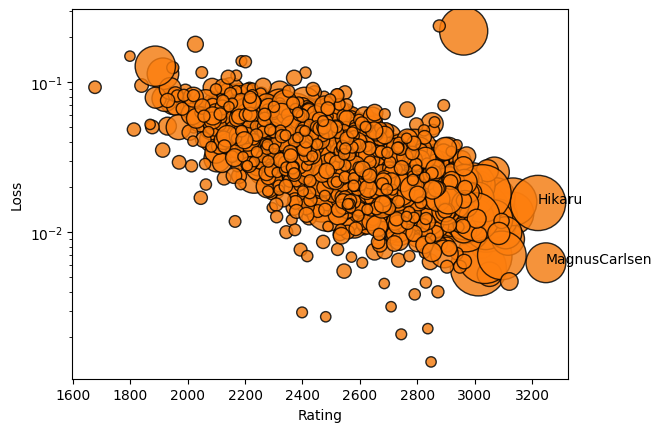

In [29]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played
min_games = 10

plt.scatter(df.loc[df["games"] > min_games, "rating"], df.loc[df["games"] > min_games,"loss"], s= [5 * x for x in df.loc[df["games"] > min_games,"games"].to_list()],alpha =.2)
# Black outline for each marker
plt.scatter(df.loc[df["games"] > min_games,"rating"], df.loc[df["games"] > min_games,"loss"], s= [5 * x for x in df.loc[df["games"] > min_games,"games"].to_list()], edgecolors="black",alpha =0.8)
# set y log
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Rating")


for i, txt in enumerate(df.loc[df["games"] > min_games].index):
    if df.loc[df["games"] > min_games,"rating"][i] > 3200:
        plt.annotate(txt, (df.loc[df["games"] > min_games,"rating"][i], df.loc[df["games"] > min_games,"loss"][i]), fontsize=10)
    if df.loc[df["games"] > min_games,"loss"][i] > 0.25:
        plt.annotate(txt, (df.loc[df["games"] > min_games,"rating"][i], df.loc[df["games"] > min_games,"loss"][i]), fontsize=10)
    if df.loc[df["games"] > min_games,"loss"][i] < 0.001 and df.loc[df["games"] > min_games,"rating"][i] < 2900:
        plt.annotate(txt, (df.loc[df["games"] > min_games,"rating"][i], df.loc[df["games"] > min_games,"loss"][i]), fontsize=10)
    


/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/1723319160.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["rating"][i] > 3200:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/1723319160.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["loss"][i] > 0.5:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/1723319160.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


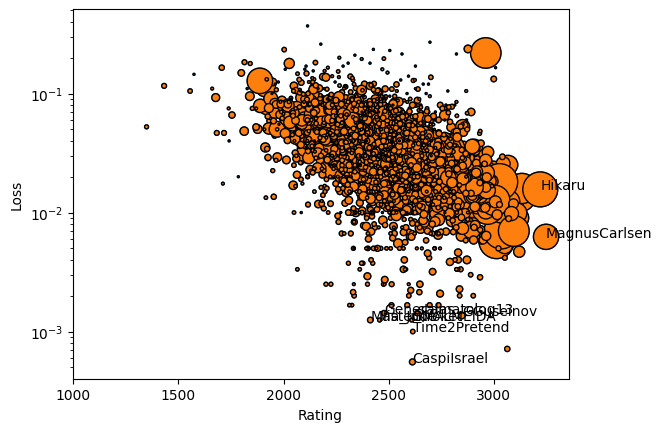

In [30]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played

plt.scatter(df["rating"], df["loss"], s= [2*x for x in df["games"].to_list()])
# Black outline for each marker
plt.scatter(df["rating"], df["loss"], s= [2*x for x in df["games"].to_list()], edgecolors="black")
# set y log
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Rating")

for i, txt in enumerate(df.index):
    if df["rating"][i] > 3200:
        plt.annotate(txt, (df["rating"][i], df["loss"][i]), fontsize=10)
    if df["loss"][i] > 0.5:
        plt.annotate(txt, (df["rating"][i], df["loss"][i]), fontsize=10)
    if df["loss"][i] < 0.0015 and df["rating"][i] < 2900:
        plt.annotate(txt, (df["rating"][i], df["loss"][i]), fontsize=10)

/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/3019696348.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["rating"][i] > 3200:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/3019696348.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["avg_rank"][i] < 1:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/3019696348.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

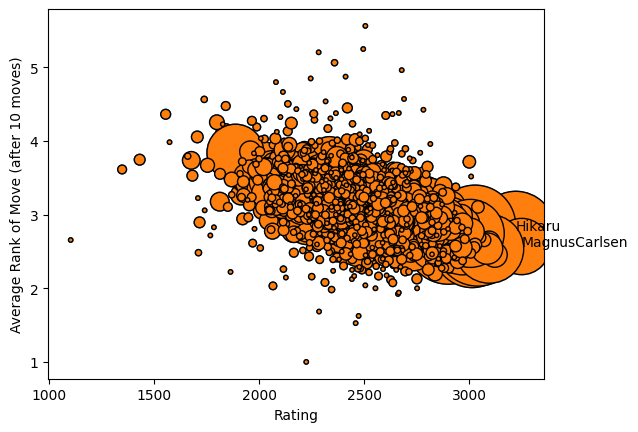

In [31]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played

plt.scatter(df["rating"], df["avg_rank"], s= [10 * x for x in df["games"].to_list()])
# Black outline for each marker
plt.scatter(df["rating"], df["avg_rank"], s= [10 * x for x in df["games"].to_list()], edgecolors="black")
plt.ylabel("Average Rank of Move (after 10 moves)")
plt.xlabel("Rating")


for i, txt in enumerate(df.index):
    if df["rating"][i] > 3200:
        plt.annotate(txt, (df["rating"][i], df["avg_rank"][i]), fontsize=10)
    if df["avg_rank"][i] < 1:
        plt.annotate(txt, (df["rating"][i], df["avg_rank"][i]), fontsize=10)

/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/2086998393.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df.games > 5,"rating"][i] > 3200:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/2086998393.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df.games > 5,"perc_best_move_after_10"][i] > 0.8:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_58592/2086998393.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

(0.3, 0.6)

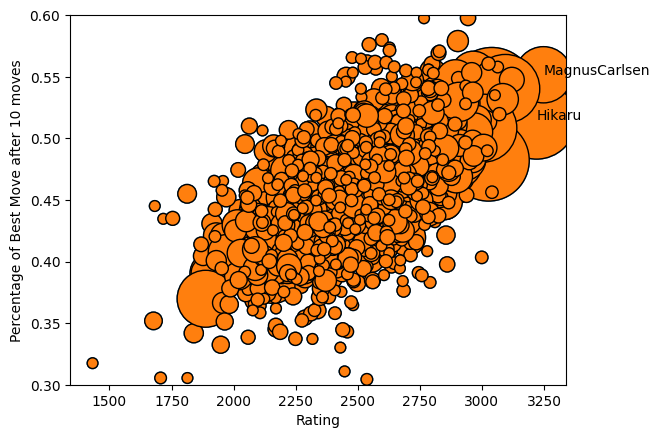

In [33]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played

plt.scatter(df.loc[df.games > 5, "rating"], df.loc[df.games > 5,"perc_best_move_after_10"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()])
# Black outline for each marker
plt.scatter(df.loc[df.games > 5,"rating"], df.loc[df.games > 5,"perc_best_move_after_10"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()], edgecolors="black")
plt.ylabel("Percentage of Best Move after 10 moves")
plt.xlabel("Rating")

for i, txt in enumerate(df.loc[df.games > 5].index):
    if df.loc[df.games > 5,"rating"][i] > 3200:
        plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"perc_best_move_after_10"][i]), fontsize=10)
    if df.loc[df.games > 5,"perc_best_move_after_10"][i] > 0.8:
        plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"perc_best_move_after_10"][i]), fontsize=10)

plt.ylim(0.3,0.6)

/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_20998/3994183098.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df.games > 5,"rating"][i] > 3200:
/var/folders/pg/2s2kg5_139ndnl_1k0654rrm0000gn/T/ipykernel_20998/3994183098.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"very_good_move"][i]), fontsize=10, zorder = 10)


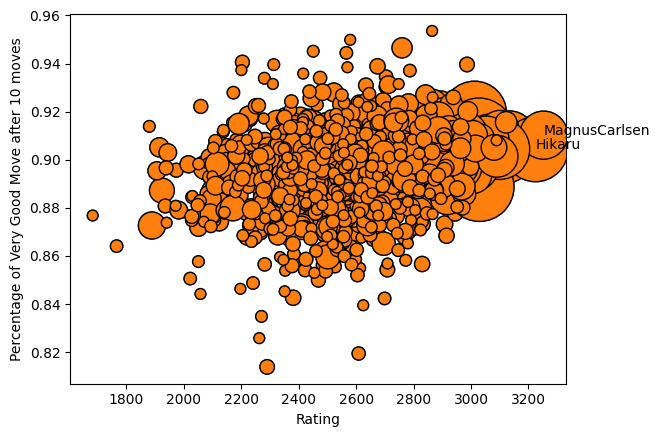

In [ ]:

plt.scatter(df.loc[df.games > 5,"rating"], df.loc[df.games > 5,"very_good_move"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()])
# Black outline for each marker
plt.scatter(df.loc[df.games > 5,"rating"], df.loc[df.games > 5,"very_good_move"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()], edgecolors="black")
plt.ylabel("Percentage of Very Good Move after 10 moves")
plt.xlabel("Rating")
# For players with rating > 3000 add name
for i, txt in enumerate(df.loc[df.games > 5].index):
    if df.loc[df.games > 5,"rating"][i] > 3200:
        plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"very_good_move"][i]), fontsize=10, zorder = 10)